# Predicting future Warming Stripes with a Quantum Long Term Short Memory (qLSTM) Model


### Authors:

Felix Lehner, Jonas Michel, Dr. Stefan Kister

### Abstract:

For this qLSTM demonstrator we use public data from a MetOffice database (https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/download.html) which is used to create the warming stripes (https://showyourstripes.info/)provided by Ed Hawkins from University of Reading (UK)https://research.reading.ac.uk/meteorology/people/ed-hawkins/). 

The data shows the global temperature for every year since 1880, so that data source is small which we assume might be an advantage for a quantum approach. It is scaled relatively to the average of the temperature of 1951-1980 to get a data range between -1 and 1 which is then represented in a specific color scheme in the stripes diagram. For the data there is also a 95% confidence intervall given, details on this uncertainty model can be found here (https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018JD029522).

<break>
    GLOBAL WARMING STRIPES 2023
<BREAK>
    
</BREAK>
<img src="./data/GLOBE_stripes_2023.png" width="900"/>

We use for prediction of this time series of temperature data with an LSTM model in a classical PyTorch workflow. The quantum part is used to represent the weights in the LTSM cell which is integrated via a Torch connector of Qiskit into PyTorch.

In [8]:
from qiskit_aer import Aer
from qiskit_ibm_runtime import  Options
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanAbsoluteError, MeanSquaredError

import sys
sys.path.append("../")

from utils.data_processing import time_window, time_window_batch
from utils.measurements import create_pauli_ops
from torchQLSTM.QLSTM import QuantumLongShortTermMemory


sns.set_theme()
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)




## Load climate data

The next code blocks processes temperature anomaly data and visualizes it using a color-coded stripe chart. Here's a simplified description:

1. **Setting up**:
   - Defines a time period from 1850 to 2018.
   - Sets a reference period (1971-2000) to calculate an average anomaly for comparison.
   - Reads temperature anomaly data from a CSV file.

2. **Calculating the Reference**:
   - Extracts and cleans anomaly data, then calculates the mean anomaly for the reference period.

3. **Color Scale**:
   - Establishes a gradient color scale (from blue to red) to indicate temperature changes.

4. **Creating the Stripe Chart**:
   - Sets up a blank figure without axes.
   - Creates a rectangular patch for each year in the data range.
   - Colors each rectangle based on the anomaly data, using the defined color scale.
   - Adjusts the color limits for better visual contrast.
   - Arranges and saves the chart as 'warming-stripes.png'.

In short, this code prepares and visualizes historical temperature anomalies as colored stripes, making it easy to see changes over time.

In [9]:
FIRST = 1850
LAST = 2018  # inclusive

# Reference period for the center of the color scale

FIRST_REFERENCE = 1971
LAST_REFERENCE = 2000
LIM = 0.7 # degrees

df = pd.read_csv(
    #'./data/NASA_GISS_GISTEMPv4.csv',
    './data/MetOffice_HadCRUT4.csv',
    sep=';',
    header=0,
    names=['year', 'anomaly'],
    index_col=[0],
    #usecols=[0,1]
    
    
)

anomaly = df.loc[FIRST:LAST, 'anomaly'].dropna()
reference = anomaly.loc[FIRST_REFERENCE:LAST_REFERENCE].mean()

cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])



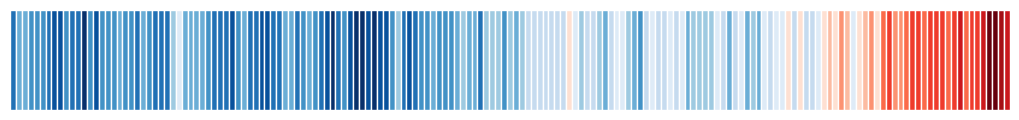

In [10]:
fig = plt.figure(figsize=(10, 1))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

# create a collection with a rectangle for each year

col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(FIRST, LAST + 1)
])

# set data, colormap and color limits

col.set_array(anomaly)
col.set_cmap(cmap)
col.set_clim(reference - LIM, reference + LIM)
ax.add_collection(col)

ax.set_ylim(0, 1)
ax.set_xlim(FIRST, LAST + 1)

fig.savefig('warming-stripes.png')

Next the temperature anomaly data is prepared for the QLSTM model. It splits the data into training (up to 2005), validation (2006-2018), and testing (2019-2023) sets, cleans it, and indexes it by year. It then adds new columns to capture anomaly values shifted by 2 and 5 years, enhancing temporal context. Using `MinMaxScaler`, the data is normalized so that all values are between 0 and 1. The same scaling method is applied consistently across the training, validation, and test sets to maintain uniformity. Finally, it trims the initial rows affected by the shifting process to ensure clean datasets for model training.


In [11]:
# Creating data for training and testing
LAST_TRAIN =2005
LAST_VALID =2018
LAST_TEST = 2023


train_df = df.loc[FIRST:LAST_TRAIN, 'anomaly'].dropna().reset_index().set_index("year")
valid_df = df.loc[LAST_TRAIN+1:LAST_VALID, 'anomaly'].dropna().reset_index().set_index("year")
test_df = df.loc[LAST_VALID+1:LAST_TEST, 'anomaly'].dropna().reset_index().set_index("year")

train_df = pd.concat([train_df,train_df['anomaly'].shift(periods=[2,5])],axis=1)
valid_df = pd.concat([valid_df,valid_df['anomaly'].shift(periods=[2,5])],axis=1)
test_df = pd.concat([test_df,test_df['anomaly'].shift(periods=[2,5])],axis=1)

train_scaler_amount=MinMaxScaler()
train_scaler_account=MinMaxScaler()
train_df=train_scaler_amount.fit_transform(train_df[['anomaly','anomaly_2','anomaly_5']])[5:,:]
# train_df=np.diff(history_train,axis=0)[5:,:]

#Validation data dont need a separate scaler. 
valid_df=train_scaler_amount.transform(valid_df[['anomaly','anomaly_2','anomaly_5']])[5:,:]
# valid_df=np.diff(history_valid,axis=0)[5:,:]

test_df=train_scaler_amount.transform(test_df[['anomaly','anomaly_2','anomaly_5']])[5:,:]
# test_df=np.diff(history_test,axis=0)[5:,:]

Next, the scaled and transformed temperature anomaly data is plotted over time. The visualization reveals a clear trend of rising temperatures.

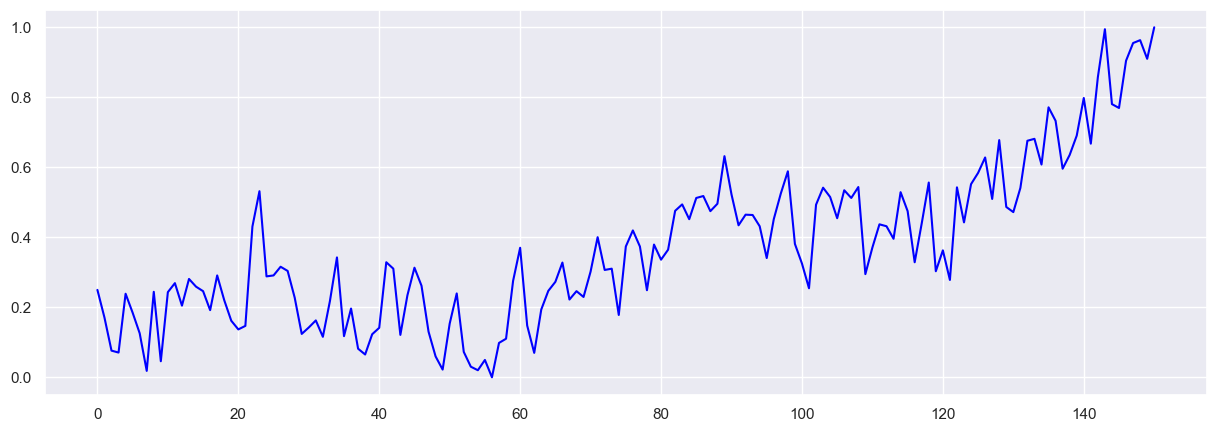

In [12]:
plt.figure(figsize=(15,5))
plt.plot(train_df[:,0], color='blue', label='Train data')

## Load QLSTM Module

In [13]:
QLSTM = QuantumLongShortTermMemory()

Create a slider window for training.

In [14]:
length=5

In [ ]:
train_window=time_window_batch(train_df,length,  1)
valid_window=time_window_batch(valid_df,length, 1)

test_window=time_window_batch(test_df,length, 1)

Initialize the QModel in a PyTorch way.

In [ ]:
class QModel(nn.Module):

    def __init__(self, 
                input_size,
                hidden_dim,
                target_size,
                noise_model
                 ):
        super(QModel, self).__init__()

        seed = 71
        np.random.seed = seed
        torch.manual_seed=seed
        
        self.lstm = QLSTM(feature_map="fm_1", ansatz="ghz", ansatz_reps=2, backend="aer_sv", noise_model=noise_model, input_size=input_size, hidden_size = hidden_dim)

        # The linear layer that maps from hidden state space to target space
        self.dense = nn.Linear(hidden_dim, target_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        dense_out = self.dense(lstm_out)
        out_scores=dense_out
        # out_scores = F.log_softmax(dense_out, dim=1)
        return out_scores

### Training of the QLSTM model
Training the QLSTM model is similar to training a standard LSTM model and does not require any special setup. However, the QLSTM model includes additional parameters, creating a larger solution space. While this can potentially lead to more accurate solutions, it also makes finding the optimal solution more challenging.

In [ ]:
###############################
# Change manually this params
###############################
input_size = 3
hidden_dim = 4
n_epochs = 10
target_size = 1
batch_size = 1

print(f"Input dim:    {input_size}")
print(f"LSTM output size: {hidden_dim}")
print(f"Training epochs:  {n_epochs}")


options = Options()
options.execution.shots = 10
shots = 100
hh= True 
while hh:

    model = QModel(input_size,
                    hidden_dim,
                    target_size,
                    'qe'
                    )
    loss_function = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=0.01, momentum=0.2)



    model.lstm.clayer_in.requires_grad_(False)
    model.lstm.clayer_out.requires_grad_(False)

    history = {
        'train_loss': [],
        'valid_loss': [],
        'mae': [],
        'mse': []
    }

    for epoch in range(n_epochs):
        train_losses = []
        preds = []
        targets = []
        model.train()
        
        for i,X in enumerate(tqdm(train_window)):

            if i ==len(train_window)-1:
                break;
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            # Step 3. Run our forward pass.
            X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
            out_scores = model(X_in)[-1]
        # out_scores = model(X_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            # label= torch.Tensor([X[1]]).reshape((length,1))
            label= torch.Tensor([X[1]]).reshape((batch_size,1))
            loss = loss_function(out_scores,label)
            loss.backward()
            optimizer.step()
            train_losses.append(float(loss))

            # probs = torch.softmax(out_scores, dim=-1)
            # preds.append(probs.argmax(dim=-1))
            preds.append(torch.Tensor(out_scores.detach()))
            # targets.append(label[-1])
            targets.append(label)
            
        valid_losses = []
        model.eval()     
        for i,X in enumerate(tqdm(valid_window)):
            if i ==len(valid_window)-1:
                break;
            X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
            try:
                out_scores = model(X_in)[-1]
            except Exception as e:
                print("There was a mistake in the qiskit code: ",e) 
                continue     
            label= torch.Tensor([X[1]]).reshape((batch_size,1))
            loss = loss_function(out_scores,label)
            valid_losses.append(float(loss))

        avg_loss_train = np.mean(train_losses)
        avg_loss_valid = np.mean(valid_losses)
        history['train_loss'].append(avg_loss_train)
        history['valid_loss'].append(avg_loss_valid)
        # print("preds", preds,targets)
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        mean_abs_error = MeanAbsoluteError()
        mae=mean_abs_error(preds, targets)
        mean_sqrt_error = MeanSquaredError()
        mse=mean_sqrt_error(preds, targets)
        history['mae'].append(mae)
        history['mse'].append(mse)
        
        if mae > 0.15:
            hh =True
            break;
        else: 
            hh=False
        print(f"Epoch {epoch + 1} / {n_epochs}: Loss = {avg_loss_train:.3f} Valid Loss: {avg_loss_valid:.3f} MAE = {mae:.4f} MSE = {mse:.4f}")


### Evaluate the model loss and outcomes/predictions

In [ ]:
plt.plot(history['train_loss'])
#plt.plot(history['valid_loss'])

In [ ]:
train_predictions=np.array([])
model.eval()
for i,y in enumerate(train_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        train_predictions=np.append(train_predictions,pred.detach().numpy())
    except: 
        pred=1
        train_predictions=np.append(train_predictions,pred)
    

In [ ]:
predictions=np.array([])
test_labels=np.array([])
for i,y in enumerate(test_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        predictions=np.append(predictions,pred.detach().numpy())
        test_labels= np.append(test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        predictions=np.append(predictions,pred)
        test_labels= np.append(test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
t_predictions=torch.from_numpy(predictions)
t_test_labels=torch.from_numpy(test_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(t_predictions, t_test_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(t_predictions, t_test_labels)
print("MAE Test",mae)
print("MSE Test",mse)

In [ ]:
valid_labels=np.array([])
valid_predictions=np.array([])
for i,y in enumerate(valid_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        valid_predictions=np.append(valid_predictions,pred.detach().numpy())
        valid_labels= np.append(valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        valid_predictions=np.append(valid_predictions,pred)    
        valid_labels= np.append(valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
        
t_predictions=torch.from_numpy(valid_predictions)
t_valid_labels=torch.from_numpy(valid_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(t_predictions, t_valid_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(t_predictions, t_valid_labels)
print("MAE Valid",mae)
print("MSE Valid",mse)

In [ ]:
fig = plt.figure(figsize=(10, 1))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(+1, LAST + 1)
])

# set data, colormap and color limits

col.set_array(train_df.reshape(-1))
col.set_cmap(cmap)
col.set_clim(reference - LIM, reference + LIM)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(LAST_VALID+1, LAST + 1)

# plt.figure(figsize=(15,5))
# plt.plot(np.arange(len(train_df[:,0])),train_df[:,0], color='blue', label='Train data')
plt.show()


In [ ]:
####### ZII, IZI, IIZ 
plt.figure(figsize=(16,5))

plt.plot(train_df[:,0], color='black', label='Train data')
plt.plot(length+np.arange(len(train_predictions)),train_predictions, color='black', label='Train Prediction',linestyle='dashed')

plt.plot(len(train_df)+np.arange(len(valid_df)),valid_df[:,0], color='green', label='Valid data')
plt.plot(length+len(train_df)+np.arange(len(valid_predictions)),valid_predictions, color='green', label='Valid Prediction',linestyle='dashed')

plt.plot(len(train_df)+len(valid_df)+np.arange(len(test_df_new)),test_df_new[:,0], color='blue', label='Test data')
plt.plot(length+len(train_df)+len(valid_df)+np.arange(len(predictions)),predictions, color='red', label='Predicted data',linestyle='dashed')

plt.axvline(len(train_df), linestyle=':')

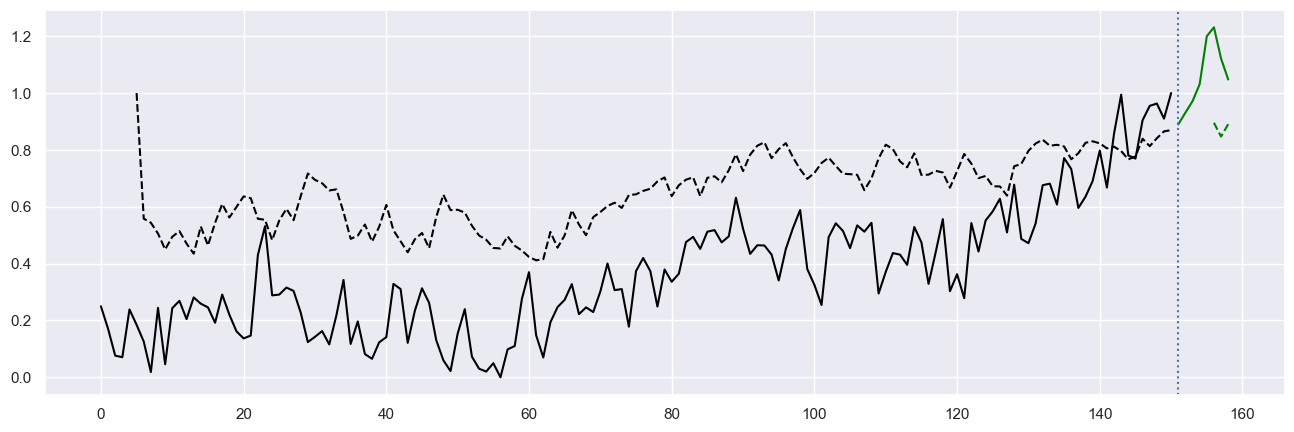

## Classical LSTM 
In this section, a classical LSTM model is used and trained with the same data as the QLSTM model. While some parameter values may differ slightly, the number of parameters is kept consistent to ensure a fair comparison.

In [ ]:
class Model_LSTM(nn.Module):

    def __init__(self, 
                    input_dim,
                    hidden_dim, 
                    batch_size, 
                    target_size, 
                    
                 ):
        super(Model_LSTM, self).__init__()

        seed = 71
        np.random.seed = seed
        torch.manual_seed=seed
        
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        #self.dropout = nn.Dropout(0.2)
        # The linear layer that maps from hidden state space to target space
        self.dense = nn.Linear(hidden_dim, target_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        #out = self.dropout(out)
        dense_out = self.dense(out)
        out_scores=dense_out
        # out_scores = F.log_softmax(dense_out, dim=1)
        return out_scores

In [ ]:
###############################
# Change manually this params
###############################
input_size = 3
hidden_dim = 4
n_epochs = 10
target_size = 1
batch_size= 1

print(f"Input dim:    {input_size}")
print(f"LSTM output size: {hidden_dim}")
print(f"Number of qubits: {n_qubits}")
print(f"Training epochs:  {n_epochs}")

model_lstm = Model_LSTM(input_size,
                hidden_dim,
                batch_size,
                target_size=target_size,
                )

def count_parameters(model_lstm):
    return sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)

print(f"Model Parameters:  {count_parameters(model_lstm)}")

loss_function = nn.MSELoss()
#optimizer = optim.RMSprop(model.parameters(), lr=0.01) #Original
# optimizer = optim.RMSprop(model_lstm.parameters(), lr=0.01,momentum=0.2)

optimizer = optim.RMSprop(model_lstm.parameters(), lr=0.001,momentum=0.2)

model_lstm.dense.requires_grad_(False)

history = {
    'train_loss': [],
    'valid_loss': [],
    'mae': [],
    'rmse': []
}
for epoch in range(n_epochs):
    train_losses = []
    preds = []
    targets = []
    model_lstm.train()
    
    for i,X in enumerate(tqdm(train_window)):

        if i ==len(train_window)-1:
            break;
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Step 3. Run our forward pass.
        X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
        try:
            out_scores = model_lstm(X_in)[-1]
        except Exception as e:
            print("There was a mistake in the code: ",e) 
            continue        # out_scores = model(X_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        # label= torch.Tensor([X[1]]).reshape((length,1))
        label= torch.Tensor([X[1]]).reshape((batch_size,1))
        loss = loss_function(out_scores,label)
        loss.backward()
        optimizer.step()
        train_losses.append(float(loss))

        # probs = torch.softmax(out_scores, dim=-1)
        # preds.append(probs.argmax(dim=-1))
        preds.append(torch.Tensor(out_scores.detach()))
        # targets.append(label[-1])
        targets.append(label)
        
    valid_losses = []
    model_lstm.eval()     
    for i,X in enumerate(tqdm(valid_window)):
        if i ==len(valid_window)-1:
            break;
        X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
        try:
            out_scores = model_lstm(X_in)[-1]
        except Exception as e:
            print("There was a mistake in the  code: ",e) 
            continue     
        label= torch.Tensor([X[1]]).reshape((batch_size,1))
        loss = loss_function(out_scores,label)
        valid_losses.append(float(loss))

    avg_loss_train = np.mean(train_losses)
    avg_loss_valid = np.mean(valid_losses)
    history['train_loss'].append(avg_loss_train)
    history['valid_loss'].append(avg_loss_valid)
    #print("preds", preds,targets)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    mean_abs_error = MeanAbsoluteError()
    mae=mean_abs_error(preds, targets)
    mean_sqrt_error = MeanSquaredError()
    rmse=mean_sqrt_error(preds, targets)
    history['mae'].append(mae)
    history['rmse'].append(rmse)

    print(f"Epoch {epoch + 1} / {n_epochs}: Loss = {avg_loss_train:.3f} Valid Loss: {avg_loss_valid:.3f} MAE = {mae:.4f} RMSE = {rmse:.4f}")


In [ ]:
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])

In [ ]:
lstm_train_predictions=np.array([])
model.eval()
for i,y in enumerate(train_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model_lstm(test_tensor)[-1]
        lstm_train_predictions=np.append(lstm_train_predictions,pred.detach().numpy())
    except: 
        pred=1
        lstm_train_predictions=np.append(lstm_train_predictions,pred)

lstm_valid_labels=np.array([])
lstm_valid_predictions=np.array([])
for i,y in enumerate(valid_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model_lstm(test_tensor)[-1]
        lstm_valid_predictions=np.append(lstm_valid_predictions,pred.detach().numpy())
        lstm_valid_labels= np.append(lstm_valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        lstm_valid_predictions=np.append(lstm_valid_predictions,pred)    
        lstm_valid_labels= np.append(lstm_valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
        
lstm_t_valid_predictions=torch.from_numpy(lstm_valid_predictions)
lstm_t_valid_labels=torch.from_numpy(lstm_valid_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(lstm_t_valid_predictions, lstm_t_valid_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(lstm_t_valid_predictions, lstm_t_valid_labels)
print("MAE Valid",mae)
print("MSE Valid",mse)

lstm_predictions=np.array([])
lstm_test_labels=np.array([])
for i,y in enumerate(test_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model_lstm(test_tensor)[-1]
        lstm_predictions=np.append(lstm_predictions,pred.detach().numpy())
        lstm_test_labels= np.append(lstm_test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        lstm_predictions=np.append(lstm_predictions,pred)
        lstm_test_labels= np.append(lstm_test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))

lstm_t_predictions=torch.from_numpy(lstm_predictions)
lstm_t_test_labels=torch.from_numpy(lstm_test_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(lstm_t_predictions, lstm_t_test_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(lstm_t_predictions, lstm_t_test_labels)
print("MAE Test",mae)
print("MSE Test",mse)    

In [ ]:
####### ZII, IZI, IIZ 
plt.figure(figsize=(16,5))

plt.plot(train_df[:,0], color='black', label='Train data')
plt.plot(length+np.arange(len(lstm_train_predictions)),lstm_train_predictions, color='black', label='Train Prediction',linestyle='dashed')

plt.plot(len(train_df)+np.arange(len(valid_df)),valid_df[:,0], color='green', label='Valid data')
plt.plot(length+len(train_df)+np.arange(len(lstm_valid_predictions)),lstm_valid_predictions, color='green', label='Valid Prediction',linestyle='dashed')

plt.plot(len(train_df)+len(valid_df)+np.arange(len(test_df_new)),test_df_new[:,0], color='blue', label='Test data')
plt.plot(length+len(train_df)+len(valid_df)+np.arange(len(lstm_predictions)),lstm_predictions, color='red', label='Predicted data',linestyle='dashed')

plt.axvline(len(train_df), linestyle=':')

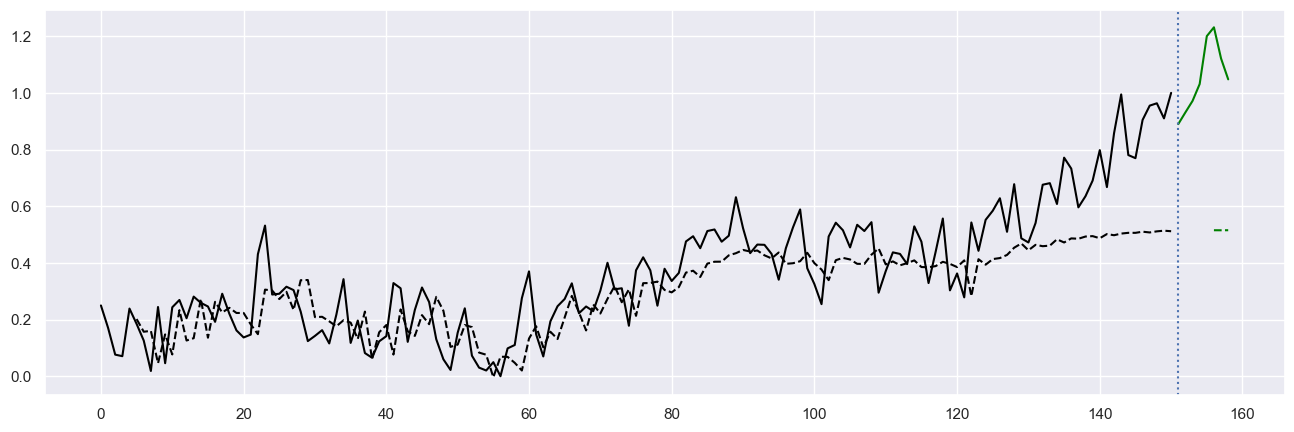

# Summary

The two graphs (QLSTM and LSTM predictions) above illustrate the performance of the classical LSTM model and the Quantum LSTM (QLSTM) model, respectively, in predicting temperature anomalies.
In the first graph, representing the QLSTM model, we observe a relatively smooth and steady trend that captures the general trajectory of the temperature anomalies. The dashed line indicates the prediction, which aligns reasonably well with the trend but may miss finer details.

In the second graph, representing the classical LSTM model, the predictions also follow the overall increasing trend in temperature anomalies. The LSTM model offers a more nuanced representation with pronounced fluctuations, suggesting it captures more intricate patterns in the data.

It is important to note that training the QLSTM required significantly more time compared to the classical LSTM model. The additional complexity and parameters in the QLSTM model contribute to the extended training duration.
In summary, while both models effectively identify the rising trend in temperature anomalies, the QLSTM model provides a better trend recognition at the cost of longer training times. This comparison highlights the trade-off between model precision and computational efficiency.